<a href="https://colab.research.google.com/github/audrb1999/DL-Project/blob/main/4.Mobilenet_%EA%B2%BD%EB%9F%89%ED%99%94/Mobilenet_%EA%B2%BD%EB%9F%89%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mobilenet 경량화

1. resnet의 bottleneck 개념을 적용
  -  $3 \times 3$ depthwise conv하기 전에 채널 수를 $\frac 1 2$로 줄이고 이후에 2배로 다시 늘려줌
  - 연산량이 많은 conv layer에서 발생하는 parameter를 줄임

2. resnet의 shortcut으로 accuracy를 높임

3. Grouped Fully Convolutional layer를 사용하여 연산량을 줄임



###1. Bottleneck

$1 \times 1$ convolution을 통해서 적은 연산량으로 Feature map을 조절 = bottleneck의 핵심

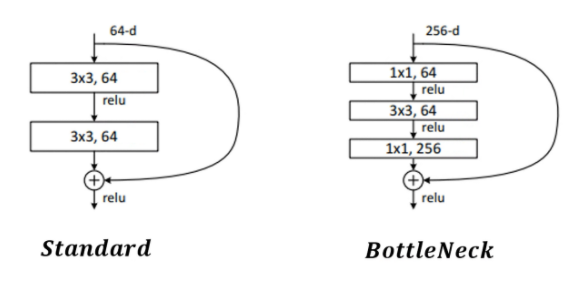

두 방법의 차이를 보면 

standard의 경우 1152개의 파라미터가 존재하는 반면 bottleneck을 적용할 시 896개로 파라미터를 축소할 수 있습니다.

1. 첫 번째로는 $1 \times 1$ convolution으로 채널을 압축하여 연산량을 줄입니다. 
  - 이 부분은 오직 연산량을 줄이는 압축만을 포함합니다. 
  - convolution 연산이 공간적인 특징을 추출하기 위해선 kernel이 최소 2 이상이 되어야 합니다.

2. 그 다음 이제 본격적인 특징 추출을 진행합니다.
  - $3 \times 3$ convolution으로 특성을 추출합니다.
  - $3 \times 3$ convolution은 위에서 사용한 $1 \times 1$ convolution보다 연산량이 9배 많기 때문에 채널을 압축한 뒤 특성을 추출했습니다.

3. 마지막으로 원래 input 채널로 다시 복구 시킵니다. 







-  bottleneck 구조는 kernel size가 1인 convolution을 사용하여 연산량을 최소화하는 방법입니다. 

- 하지만 이렇게 강제로 채널을 줄이면 모델의 정확도도 떨어지게 됩니다. = 서로 tradeoff 관계이므로 적절한 합의점을 찾는 것이 중요! (여기서는 2배 줄임)

### 2. Shortcut

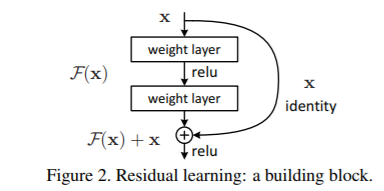

$x$는 input인데 몇 개의 레이어를 지난 다음 자신(identity)인 $x$가 더해져서 output이 $F(x) + x$가 나오게 하는 구조입니다.

- 이전 데이터에서 얼마나 변했는지 residual을 계산하여 원본 데이터와 차이를 줄이는 방향으로 convolution을 진행



### 3. Grouped convolution layer

FC층을 Grouped convolution layer으로 교체하여 연산량에서 이득을 봄

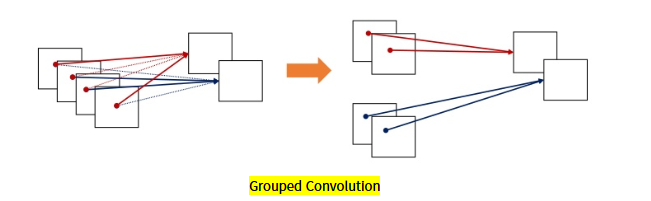

다음과 같이 입력 값의 채널들을 여러 개의 그룹으로 나누어 독립적으로 convolution 연산을 수행하는 방식으로 병렬 처리에 유리하다여 낮은 파라미터 수와 연산량을 가지게 됩니다.

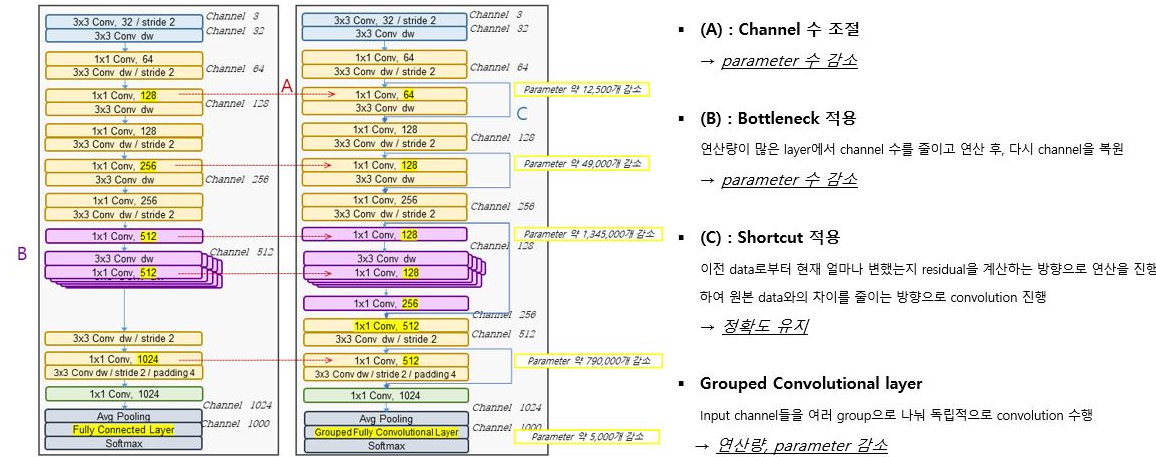

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import glob
import PIL
from PIL import Image
from torch.utils import data as D
from torch.utils.data.sampler import SubsetRandomSampler
import random
import torchsummary
import time



In [2]:
batch_size = 64 
validation_ratio = 0.1
random_seed = 10

In [3]:
#데이터셋 설정
transform_train = transforms.Compose([ # 이미지 전처리
        transforms.Resize(224), # 이미지들을 전부 같은 사이즈로 조정

        ### 오버피팅을 방지하기 위해 RandomCrop과 Randam HorizontalFlip같은 노이즈 추가.
        transforms.RandomCrop(224, padding=28), #오버피팅 막으려고 랜덤으로 잘라서 이미지 만든다
        transforms.RandomHorizontalFlip(), # 오버피팅 막으려고 이미지를 수평으로 반전시켜서 만든다
        transforms.ToTensor(), # 데이터 타입을 tensor 형태로 변경
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]) # 각 채널 별로 mean std 값을 할당
        # 첫 번째 튜플은 mean 두 번째는 standard 

#validation이나 test는 그런 것 필요 없음
transform_validation = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])


transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])


#데이터 세트 다운로드

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

validset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_validation)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                          shuffle=True, num_workers=0)


# 데이터 나눠주기
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(validation_ratio * num_train))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# train_loader에 데이터를 로드 해오는 코드들
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler, num_workers=0
)

valid_loader = torch.utils.data.DataLoader(
    validset, batch_size=batch_size, sampler=valid_sampler, num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=0
)

#10개 클래스로 구분
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 초기 학습률
initial_lr = 0.1

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


1. depthwise conv 만들기

In [4]:
class depthwise_conv(nn.Module):
    # __init__()에서 모델의 구조와 동작을 정의하는 생성자를 정의(속성값을 초기화하는 역할로, 객체가 생성될 때 자동으호 호출)
    def __init__(self, nin, kernel_size, padding, bias=False, stride=1):
        super(depthwise_conv, self).__init__() # super() 함수를 부르면 여기서 만든 클래스는 nn.Module 클래스의 속성들을 가지고 초기화
        #nn.conv2D 모듈 : 첫번째는 입력 채널 수, 두번째변수는 출력 채널 수 세번째는 커널 사이즈(숫자하나만 지정하면 정사각형으로 간주)
        
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=kernel_size, stride=stride, padding=padding, groups=nin, bias=bias)
        #self.depthwise는 이제 nin 크기의 받아서 nin 크기의 출력을 하는 conv2D 함수가 됨.

    #foward() 함수는 모델이 학습데이터를 입력받아서 forward 연산을 진행시키는 함수
    def forward(self, x):
        out = self.depthwise(x)  #self.depthwise 실행하고 반환
        return out

In [5]:
class dw_block(nn.Module):
    def __init__(self, nin, kernel_size, padding=1, bias=False, stride=1):
        super(dw_block, self).__init__()
        self.dw_block = nn.Sequential(
            depthwise_conv(nin, kernel_size, padding, bias, stride),
            #BatchNorm2d(배치 정규화): 학습률을 너무 높게 잡으면 기울기가 소실되거나 발산하는 증상을 예방하여 학습과정을 안정화하는 방법
            nn.BatchNorm2d(nin),
            ##distribution을 평균 0, 표준편차 1인 input으로 normalize시키는 방법
            ##Training 할 때는 batch의 평균과 분산으로 normalize 하고, Test 할 때는 계산해놓은 이동 평균(training 때 계산)으로 normalize
            nn.LeakyReLU(inplace= False)
        )
    def forward(self, x):
        out = self.dw_block(x)
        return out

2. $1 \times 1 $ convolution

In [6]:
class one_by_one_block(nn.Module):
    def __init__(self, nin, nout, padding=0, bias=False, stride=1):
        super(one_by_one_block, self).__init__()
        self.one_by_one_block = nn.Sequential(
            #커널 사이즈 1x1 로 컨벌루션 진행
            nn.Conv2d(nin, nout, kernel_size=1, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(nout),
            nn.LeakyReLU(inplace= False)
        )
    def forward(self, x):
        out = self.one_by_one_block(x)
        return out

Convolution 연산전에 채널 수를 절반 줄임 32

In [7]:
class MobileNet(nn.Module):
  
    def __init__(self, input_channel, num_classes=10):
        super(MobileNet, self).__init__()
        
        self.block1 = nn.Sequential(
            #nn.conv2D 모듈 : 첫번째는 입력 채널 수, 두번째변수는 출력 채널 수 세번째는 커널 사이즈(숫자하나만 지정하면 정사각형으로 간주)
            #BatchNorm2d(배치 정규화): 학습률을 너무 높게 잡으면 기울기가 소실되거나 발산하는 증상을 예방하여 학습과정을 안정화하는 방법
            #계층에 들어가는 입력을 평균과 분산으로 정규화함.
            nn.Conv2d(input_channel, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace= False),
        )
        #112x112x32
        ###identity 저장
        self.block2=nn.Sequential(
            dw_block(32, kernel_size=3), #depthwise convolution / stride=1
        )
        # 다시 크기 늘림
        ###resnet 작용하기 위해 downsampling넣기
        self.block3=nn.Sequential( 
            nn.LeakyReLU(inplace= False),  
            one_by_one_block(32, 64), #one_by_one convolution
            #112x112x64
            dw_block(64, kernel_size=3, stride=2), 
        )
        #56x56x64
        ###identity 저장
        self.block4=nn.Sequential(
            one_by_one_block(64, 64),
            dw_block(64, kernel_size=3),
        )
        ###resnet 작용하기 위해 downsampling넣기
        self.block5=nn.Sequential(    
            one_by_one_block(64, 128),
            #56x56x128
            nn.LeakyReLU(inplace= False),
            dw_block(128, kernel_size=3, stride=2),
        )
        #28x28x128
        ###identity 저장
        self.block6=nn.Sequential( 
            one_by_one_block(128, 128),
            dw_block(128, kernel_size=3),
        )
        #resnet 작용하기 위해 downsampling넣기
        self.block7=nn.Sequential(
            one_by_one_block(128, 256),
            #28x28x256
            nn.LeakyReLU(inplace= False),
            dw_block(256, kernel_size=3, stride=2),
        )
        #14x14x256
        #identity 저장
        self.block8=nn.Sequential(
            one_by_one_block(256, 128),
            #14x14x128   
            # 5 times 
            dw_block(128, kernel_size=3),
            one_by_one_block(128, 128),
            dw_block(128, kernel_size=3),
            one_by_one_block(128, 128),
            dw_block(128, kernel_size=3),
            one_by_one_block(128, 128),
            dw_block(128, kernel_size=3),
            one_by_one_block(128, 128),
            dw_block(128, kernel_size=3),
            one_by_one_block(128, 256),
        )
        #14x14x256
        #resnet 작용하기 위해 downsampling넣기
        self.block9=nn.Sequential(
            one_by_one_block(256, 512),
            nn.LeakyReLU(inplace= False),
            dw_block(512, kernel_size=3, stride=2),
        )
        #7x7x512
        #identity 저장
        self.block10=nn.Sequential(
            one_by_one_block(512, 512),
            #7x7x512
            dw_block(512, kernel_size=3, padding=4, stride=2),
        )
        #7x7x512
        #resnet 작용하기 위해 downsampling넣기
        self.block11=nn.Sequential(
            one_by_one_block(512, 1024),
        )
        #7x7x1024
        #avgPool->1x1x1024  

        #Fully Connected layer      
        self.fc_v2 = nn.Conv2d(1024, num_classes, 1, 1, groups=2)
        
    def forward(self, x):
        x = self.block1(x)
        identity = x
        x = self.block2(x)
        #112x112x32
        x += identity

        x = self.block3(x)
        identity = x
        x = self.block4(x)
        x += identity

        x = self.block5(x)
        identity = x
        x = self.block6(x)
        x += identity

        x = self.block7(x)
        identity = x
        x = self.block8(x)
        x += identity

        x = self.block9(x)
        identity = x
        x = self.block10(x)
        x += identity
        x = self.block11(x)
        
        body_output = x
        
        avg_pool_output = F.adaptive_avg_pool2d(body_output, (1, 1))
        output = self.fc_v2(avg_pool_output)
        output = output.view(output.size(0), -1)
        
        return output

In [8]:
net = MobileNet(3, 10) #아마도 인풋채널3개(RGB), 클래스 10개 로 추정됨!

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #GPU있고 cuda를 쓸수 있으면 쿠다를 쓰게 하고 없으면 cpu 쓰게함
print(device)

cuda:0


In [10]:
net.to(device) #이용가능한 device(cpu or Gpu)에 네트워크 전송

MobileNet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): dw_block(
      (dw_block): Sequential(
        (0): depthwise_conv(
          (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        )
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
  )
  (block3): Sequential(
    (0): LeakyReLU(negative_slope=0.01)
    (1): one_by_one_block(
      (one_by_one_block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): dw_

In [11]:
torchsummary.summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
         LeakyReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
    depthwise_conv-5         [-1, 32, 112, 112]               0
       BatchNorm2d-6         [-1, 32, 112, 112]              64
         LeakyReLU-7         [-1, 32, 112, 112]               0
          dw_block-8         [-1, 32, 112, 112]               0
         LeakyReLU-9         [-1, 32, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           2,048
      BatchNorm2d-11         [-1, 64, 112, 112]             128
        LeakyReLU-12         [-1, 64, 112, 112]               0
 one_by_one_block-13         [-1, 64, 112, 112]               0
           Conv2d-14           [-1, 64,

In [ ]:
start = time.time()  # 시작 시간 저장
criterion = nn.CrossEntropyLoss() #(binary 아닌)여러 클래스의 loss구하는 함수
optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9) ##optimizer(SGD방식): 역전파과정에서 loss function의 값을 줄여나가며 학습시킴(가중치 업데이트)
torch.autograd.set_detect_anomaly(True)
for epoch in range(100):  
    if epoch == 0:
        lr = initial_lr
    elif epoch % 2 == 0 and epoch != 0:
        lr *= 0.94
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data  #데이터의 인풋 받아온다.s
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels) #결과와 라벨을 비교해서 loss를 구한다.
        loss.backward() #loss를 backward해서 기울기(미분치)를 구한다. -> 맞나?
        optimizer.step() #한 스텝 이동
        running_loss += loss.item()
        
        show_period = 250
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            print('[%d, %5d] loss: %.7f' %
                  (epoch + 1, i + 1, running_loss / show_period))
            running_loss = 0.0
       
    total = 0
    correct = 0
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct = correct + (predicted == labels).sum().item() #맞으면 correct하고 추가함
        
    print('[%d epoch] Accuracy of the network on the validation images: %d %%' % 
          (epoch+1, 100 * correct / total)
         )

print('Finished Training')
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[1,   250] loss: 1.8586882
[1,   500] loss: 1.4869409
[1 epoch] Accuracy of the network on the validation images: 51 %
[2,   250] loss: 1.1927145
[2,   500] loss: 1.0743358
[2 epoch] Accuracy of the network on the validation images: 61 %
[3,   250] loss: 0.8841775
[3,   500] loss: 0.8141757
[3 epoch] Accuracy of the network on the validation images: 67 %
[4,   250] loss: 0.7095334
[4,   500] loss: 0.6847272
[4 epoch] Accuracy of the network on the validation images: 73 %
[5,   250] loss: 0.5894355
[5,   500] loss: 0.5877246
[5 epoch] Accuracy of the network on the validation images: 75 %
[6,   250] loss: 0.5462090
[6,   500] loss: 0.5284687
[6 epoch] Accuracy of the network on the validation images: 78 %
[7,   250] loss: 0.4861108
[7,   500] loss: 0.4778531
[7 epoch] Accuracy of the network on the validation images: 77 %
[8,   250] loss: 0.4528370
[8,   500] loss: 0.4395456
[8 epoch] Accuracy of the network on the validation images: 77 %
[9,   250] loss: 0.4019545
[9,   500] loss: 0.40

CIFAR-10 데이터를 기준으로 진행했습니다.

- MobileNet v1의 경우 정확도 89.38%에 파라미터 수가 3,217,226 
- MobileNet v2의 경우 정확도 90.75%에 파라미터 수가 3,504,876 
- 제안된 모델의 경우 정확도 85%에 파라미터 수가 1,150,986으로 대략 64% 정도의 감소 효과를 봄 (epoch = 32)

> 기존 MobileNet의 경우 활성화 함수로 ReLU를 사용했는데 변경된 모델에서 사용하니까 



one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [64, 512, 7, 7]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

위와 같은 문제가 발생

 ReLU의 inplace를 False로 설정해도 오류가 계속 생겨서 LeakyReLU를 사용했습니다.

Adam, Adam p = 많이 사용

- 성능이 괜찮아짐

양자화 적용, 토치에서 자동적용 = 이것도 한번 진행

